In [6]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from bkm10 import BKM10

In [4]:
def goodness_of_fit(y_data, y_err, y_fit, n_params=None):

    y_data = np.asarray(y_data, dtype=np.float64)
    y_err  = np.asarray(y_err, dtype=np.float64)
    y_fit  = np.asarray(y_fit, dtype=np.float64)

    # Chi-squared
    chi2 = np.sum(((y_data - y_fit) / y_err)**2)

    N = len(y_data)
    if n_params is not None:
        dof = N - n_params
    else:
        dof = N
    chi2_red = chi2 / dof

    # R^2
    ss_res = np.sum((y_data - y_fit)**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    R2 = 1 - ss_res / ss_tot

    return chi2_red, R2


In [17]:
filename = 'pseudo_KM15_BKM10_Jlab_all_t2_8pars.csv'

sets = [1]

df = pd.read_csv(filename, usecols=[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18], skiprows=1,
                 names=['set', 'k', 'Q2', 'x', 't', 'phi', 'dsig_exp', 'dsig_err', 
                        'ReH', 'ReE', 'ReHt', 'ReEt', 'ImH', 'ImE', 'ImHt', 'ImEt', 'DVCS'])

# only choose columns for which experimental data exists.
df = df[df['dsig_exp'] > 0]

# angle in trento convention
df['phi'] = np.pi-np.deg2rad(df['phi'])

df = df[df['set'].isin(sets)]

df_cffs = df[['ReH', 'ReHt', 'ReE', 'DVCS']].copy()

df_kins = df[['Q2', 'x', 't']].copy()

df_dsig = df[['phi','dsig_exp', 'dsig_err']].copy()

weights = 1/(df_dsig['dsig_err'])
weights /= np.sum(weights)

df_dsig['weights'] = weights

k = df['k'].values[0]
Q2 = df['Q2'].values[0]
x = df['x'].values[0]
t = df['t'].values[0]

kinematics = BKM10(k, Q2, x, t)

input_pipeline = make_pipeline(
    MinMaxScaler()
)

kins_train = input_pipeline.fit_transform(df_kins.to_numpy())

sample_dsig = np.random.normal(loc=df_dsig['dsig_exp'], scale=df_dsig['dsig_err'])
while np.any(sample_dsig < 0):
    mask = sample_dsig < 0
    sample_dsig[mask] = np.random.normal(loc=df_dsig['dsig_exp'][mask], scale=df_dsig['dsig_err'][mask])

outs_train = df_dsig.copy()
outs_train['dsig_exp'] = sample_dsig

outs_train = shuffle(outs_train)

# convert to tensors
kins_train = tf.convert_to_tensor(kins_train, dtype=tf.float32)
outs_train = tf.convert_to_tensor(outs_train, dtype=tf.float32)

In [ ]:
def compute_loss():

    def fit_params(cffs):
        
        phi_all = tf.convert_to_tensor(outs_train[:,0], dtype=tf.float32)
        N = tf.shape(phi_all)[0]
        cffs_all = tf.tile(tf.expand_dims(cffs[0], axis=0), [N, 1])
        dsig_all = kinematics.calculate_cross_section(phi_all, cffs_all)
        
        N = tf.cast(N, tf.float32)
        y_all_exp = outs_train[:,1]
        dsig_all_err = outs_train[:,2]
        chi2 = tf.reduce_sum((y_all_exp-dsig_all)*(y_all_exp-dsig_all)/dsig_all_err)/(N-1.)

        ss_res = tf.reduce_sum((y_all_exp - dsig_all)**2)
        ss_tot = tf.reduce_sum((y_all_exp - tf.reduce_mean(y_all_exp))**2)
        R2 = 1 - ss_res / ss_tot

        return chi2, R2

    def loss_function(y_true, cffs_pred):

        phi, dsig_true, errors, weight = tf.unstack(y_true, axis=1)
        
        y_pred = kinematics.calculate_cross_section(phi, cffs_pred)
        
        chi2, r2 = fit_params(cffs_pred)
        
        dsig_true = keras.ops.log10(dsig_true)
        y_pred = keras.ops.log10(y_pred)
        weighted_mae = tf.reduce_sum(weight * tf.abs(dsig_true - y_pred))

        return weighted_mae #+ tf.abs(r2-1.)

    return loss_function


def create_model(lr=1e-1):

    scaled_input_kins = keras.Input(shape=(3,))

    init = keras.initializers.glorot_uniform()
    hidden = keras.layers.Dense(10,  kernel_initializer=init, activation='relu')(scaled_input_kins)
    hidden = keras.layers.Dense(50,  kernel_initializer=init, activation='relu')(hidden)
    hidden = keras.layers.Dense(100, kernel_initializer=init, activation='relu')(hidden)
    hidden = keras.layers.Dense(50,  kernel_initializer=init, activation='relu')(hidden)
    hidden = keras.layers.Dense(10,  kernel_initializer=init, activation='relu')(hidden)

    cff_123 = keras.layers.Dense(3, name='cff123')(hidden)
    DVCS = keras.layers.Dense(1, name='dvcs', activation='softplus')(hidden)

    predicted_cffs = keras.layers.Concatenate(
        name='predicted_cff_layer')([cff_123, DVCS])

    model = keras.Model(inputs=scaled_input_kins, outputs=predicted_cffs)

    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss=compute_loss())
    
    return model


modifyLR = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=30, min_lr=1e-5, mode='auto')

EarlyStop = keras.callbacks.EarlyStopping(
    monitor='loss', patience=30, restore_best_weights=True)

model = create_model()

history = model.fit(kins_train, outs_train,
                    epochs=500, batch_size=2, callbacks=[modifyLR, EarlyStop])


predicted_cffs = model.predict(tf.convert_to_tensor(kins_train))

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0785 - learning_rate: 0.1000
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0483 - learning_rate: 0.1000
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - learning_rate: 0.1000
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - learning_rate: 0.1000
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - learning_rate: 0.1000
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - learning_rate: 0.1000
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - learning_rate: 0.1000
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - learning_rate: 0.1000
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - learning_rate: 0.1000
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - learning_rate: 0.1000
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - learning_rate: 0.1000
Epoch 1

KM15 CFFs: [-2.56464    1.39564    2.21195    0.0315875]
Predicted CFFs: [-2.571946   1.4904414  1.3895323  0.0289294]


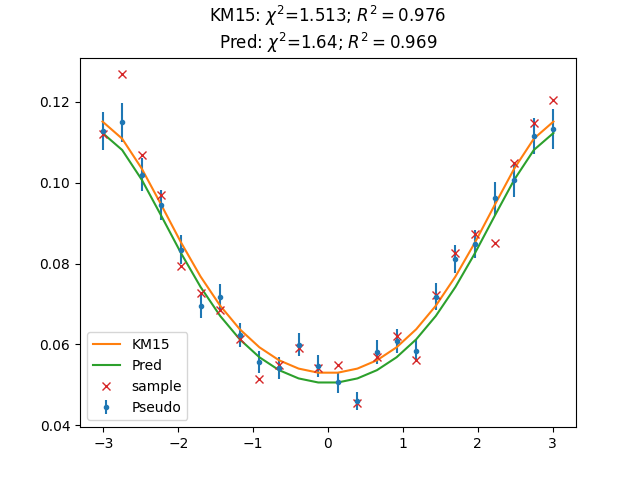

In [33]:
print('KM15 CFFs:', df_cffs.values[0])
print('Predicted CFFs:', predicted_cffs[0])

# model dsig from KM15 CFFs
modelled_dsig = kinematics.calculate_cross_section(tf.convert_to_tensor(df_dsig['phi'], dtype=tf.float32),
                                                   tf.convert_to_tensor(df_cffs, dtype=tf.float32))

predicted_dsig = kinematics.calculate_cross_section(tf.convert_to_tensor(df_dsig['phi'], dtype=tf.float32),
                                                   tf.convert_to_tensor(predicted_cffs, dtype=tf.float32))

plt.figure()
plt.errorbar(df_dsig['phi'], df_dsig['dsig_exp'], df_dsig['dsig_err'], fmt='.', label='Pseudo')
plt.plot(df_dsig['phi'], modelled_dsig, label='KM15')
plt.plot(df_dsig['phi'], predicted_dsig, label='Pred')
plt.plot(outs_train[:, 0], outs_train[:, 1], 'x', label='sample')
plt.legend()

chi2_km15, r2_km15 = goodness_of_fit(df_dsig['dsig_exp'], df_dsig['dsig_err'], modelled_dsig, 1)
chi2_pred, r2_pred = goodness_of_fit(df_dsig['dsig_exp'], df_dsig['dsig_err'], predicted_dsig, 1)

plt.title('KM15: '+r'$\chi^2$='+f'{np.round(chi2_km15, 3)}; '+r'$R^2=$'+f'{np.round(r2_km15,3)}\n'+
          'Pred: '+r'$\chi^2$='+f'{np.round(chi2_pred, 3)}; '+r'$R^2=$'+f'{np.round(r2_pred,3)}');